# Library Imports

In [46]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from pathlib import Path
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold
import warnings
import stats.stat_functions as sf
import inference.model_functions as modeling

# EDA

## Read in Data


In [2]:
dataset = pl.read_parquet('data/home_insurance.parquet')

## Initial data cleaning

First step is always to clean out the bad data from your target variable. Inital analysis show there are 
 - 16 Unknown 
 - 67115 Null
This takes us from 256136 to 189005 rows

This leaves us with 3 remaing possible flags. Lapsed (the target), canceled, active.

During the EDA I have treated these 3 flags as seperate groups when it made sense. 

The breakdown of this shows that we have a strongly imbalnced dataset with Live making up ~ 70% of the dataset

In [3]:
dataset= dataset.filter(~pl.col("pol_status").is_null(),
               pl.col("pol_status") != 'Unknown'
               )
display(dataset['pol_status'].value_counts())


pol_status,count
str,u32
"""Lapsed""",52534
"""Live""",132160
"""Cancelled""",4311


The flag column was not the only one to have null values in it. Below is the distribution of nulls between the Lapsed policies vs the remaining population. 

In [4]:
dataset = dataset.with_columns((pl.col("pol_status") == 'Lapsed').alias('lapsed_flag'))
lapsed = dataset.filter(pl.col('lapsed_flag') == 1)
null_percs = dataset.null_count()/dataset.shape[0]*100
null_percs = null_percs.transpose(include_header=True,
                             column_names = ['null_perc']).filter(pl.col('null_perc') > 0)

lapsed_null_percs = lapsed.null_count()/lapsed.shape[0]*100
lapsed_null_percs = lapsed_null_percs.transpose(include_header=True,
                                    column_names = ['null_perc_lapsed']).filter(pl.col('null_perc_lapsed') > 0)
null_percs.join(lapsed_null_percs, on='column')

column,null_perc,null_perc_lapsed
str,f64,f64
"""quote_date""",58.129679,45.248791
"""p1_pt_emp_status""",99.057168,98.795066
"""clerical""",98.442369,97.879469
"""risk_rated_area_b""",25.470226,17.116534
"""risk_rated_area_c""",4.619455,5.05387
"""campaign_desc""",100.0,100.0
"""payment_frequency""",57.38208,67.824647
"""mta_fap""",70.701833,70.299235
"""mta_aprp""",70.701833,70.299235


As can be seen from the table there are some columns with large chunks of missing data and these can just be excluded such as pe_emplyoment_status or mta_fap. 

Some of the lower value nulls are possibly worth while keeping such as the risk_rate_area_b or c due to it being a slightly richer dataset and lower percentage missing however some form of imputation would be useful here and that isn't nesscisarily obvious an answer for risk rated area. 

The other reason to do this was to see if there were any columns where there were highly different number of nulls between the population vs the lapsed subset. The aim here being to see if them lapsing either had a proxy variable we needed to be careful of as well as something that may have predictive power. 

The 2 that could be interesting here and 
- risk rated area b 
    - the lapsed customers have more information about that particular risk rated area. However as it has both Y and N flags alread imputation becomes more difficult
- payment frequency
    - The lack of richness in payment frequency again suggestts that the lapsed policies are more likely to not have a history of regular payment but as the Null doesn't seem to mean anything in this category it will be hard to impute the frequency. 

As a first pass on the dataset I decided to remove all the columns with nulls in them. There were a fair few other columns that had full information in them and if needed this can be revisited. 

In [5]:
# Processing code so that it is ready for analysis/presentation

removal_list = null_percs.get_column('column').to_list()
dataset = dataset.drop(removal_list)

date_cols = ['cover_start', 'p1_dob']
date_expresions = [pl.col(c).str.to_date()for c in date_cols]
dataset = dataset.with_columns(date_expresions)

def get_str_cols(df):
    return [col for col, dtype in df.schema.items()
    if dtype == pl.Utf8]

def get_bool_cols(df):
    return [col for col, dtype in df.schema.items()
    if dtype == pl.Boolean]

string_cols = get_str_cols(dataset)
unique_counts = dataset.select([pl.col(c).n_unique() for c in string_cols]).row(0, named=True)

# 4. Filter the string columns to keep only those with exactly 2 unique values
binary_cols = [
    col for col, n_unique in unique_counts.items()
    if n_unique == 2
]

expressions = [
    pl.col(c)
    .replace({"Y": True},default=False)
    .alias(c)
    for c in binary_cols
]
dataset_encoded = dataset.with_columns(expressions)

new_sum_cols = ["total_add_ons_pre_ren", "total_add_ons_post_ren"]

# Drop them if they exist
dataset_encoded = dataset_encoded.drop(new_sum_cols, strict=False)
pre_renual_add_ons = [x for x in dataset_encoded.columns if x.endswith('_pre_ren')]
post_renual_add_ons = [x for x in dataset_encoded.columns if x.endswith('_post_ren')]
# Generate columns needed for insight 
dataset_encoded = dataset_encoded.with_columns(
    (pl.col("cover_start").dt.year() - pl.col("p1_dob").dt.year()).alias("p1_age"),
    (pl.col("cover_start").dt.strftime("%b")).alias("cover_start_month"),
    (pl.col("cover_start").dt.year() - pl.col("yearbuilt")).alias("house_age"),
    (pl.col("sum_insured_buildings") + pl.col("sum_insured_contents")).alias("total_sum_insured"),
    ((pl.col("ncd_granted_years_b") + pl.col("ncd_granted_years_c"))/2).alias("avg_ncd_years"),
    (pl.sum_horizontal(pre_renual_add_ons)).alias(new_sum_cols[0]),
    (pl.sum_horizontal(post_renual_add_ons)).alias(new_sum_cols[1]),
    (pl.when(pl.col("p1_emp_status").is_in(["R", "E"]))
      .then(pl.col("p1_emp_status")).otherwise(pl.lit('O')).alias("p1_emp_status_simple"))
).with_columns((pl.col('total_sum_insured')/(pl.col('avg_ncd_years')+1)).alias('insured_per_ncd_year'))

## Univariate Analysis

As a starter for 10 I wanted to see if there were any obvious single variables that produced obvious differences betwee the target group. I have put a few of those graphs below. 

In [6]:
def plot_distribution_by_lapsed_status(df, column_name, target_name="pol_status"):
    graph_data = df.select([column_name, target_name])

    plt.figure(figsize=(10,6))
    sns.histplot(data=graph_data.to_pandas(), x=column_name, hue=target_name, multiple="stack", bins=30)
    plt.title(f"Distribution of {column_name} by Lapsed Status")
    plt.xlabel(column_name)
    plt.ylabel(f"Count of {target_name}")
    plt.show()

In [7]:
def violin_plot_by_lapsed_status(df, column_name, target_name="pol_status"):
    graph_data = df.select([column_name, target_name])

    plt.figure(figsize=(10,6))
    sns.violinplot(data=graph_data.to_pandas(), x=target_name, y=column_name)
    plt.title(f"Violin Plot of {column_name} by {target_name}")
    plt.xlabel(target_name)
    plt.ylabel(column_name)
    plt.show()

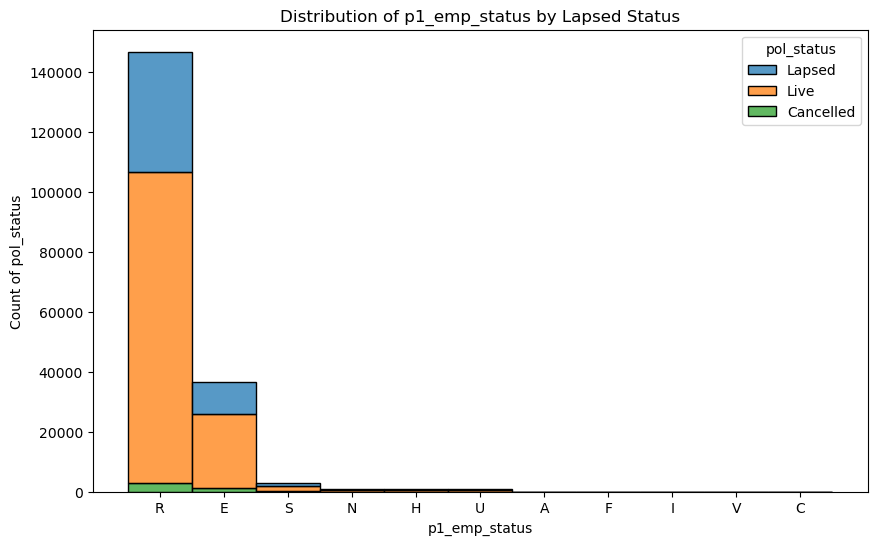

In [8]:
plot_distribution_by_lapsed_status(dataset_encoded, "p1_emp_status")

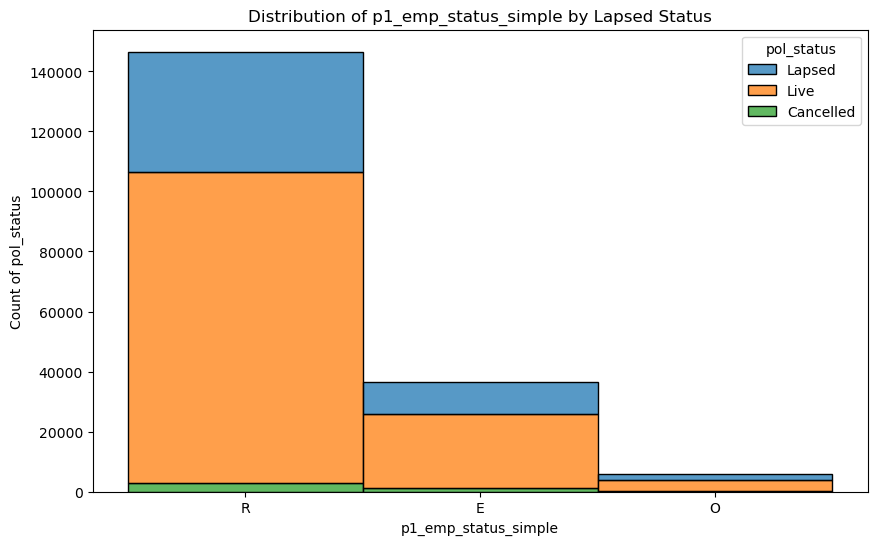

In [9]:
plot_distribution_by_lapsed_status(dataset_encoded, "p1_emp_status_simple")

The Employment stats graph was done to see if there was a single over represented group in the datset and it demonstrates quite succinctly that this is mainly a dataset of retired people. While this is starting to match the demographic of the UK as a whole it suggests that the offer targeting will need to be specific. 

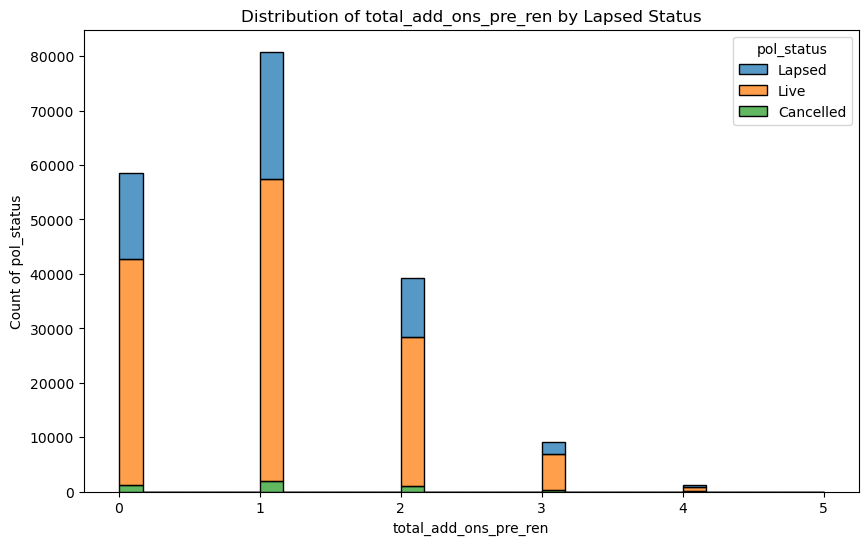

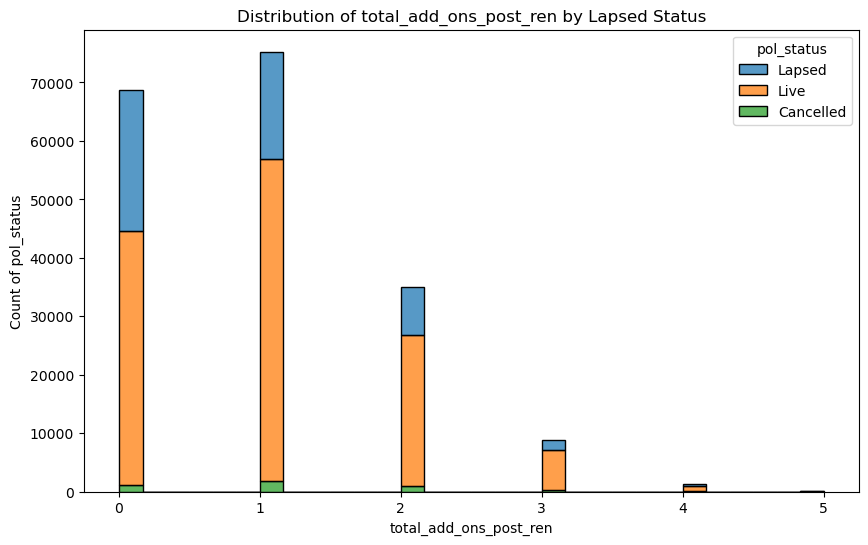

In [10]:
# total add ons post ren 
plot_distribution_by_lapsed_status(dataset_encoded, "total_add_ons_pre_ren")
plot_distribution_by_lapsed_status(dataset_encoded, "total_add_ons_post_ren")


I created a variable to track the total of add ons pre and post renual. The thought process here would be a way to intrract all the add ons that were in the dataset while seeing if they had individual or combined effect on the lapsed status.

It does show there is a slight increase in lapsed customers if they don't add anything on to their policy after their renewal. 
And it also shows a slight increase in lapsed if the customers had one or two add ons before renewal.  

## Statistical relevance

In [11]:
dataset_encoded = dataset_encoded.drop(['pol_status'])
# "ncd_granted_years_b", "total_sum_insured",

In [16]:
str_cols = get_str_cols(dataset_encoded)[:-2] # removes target and old indexes
bool_cols = get_bool_cols(dataset_encoded)[:-1] # removes target
potential_cat_vars = []

cols = str_cols + bool_cols
for col in cols:
    results = sf.chi_square_test(df=dataset_encoded,
                    categorical_col=col,
                    target_col='lapsed_flag',
                    truncated=True
                    )
    if results['significant'] == True:
        potential_cat_vars += [results['variable']]
        if results['cramers_v'] != 'Negligible':
            display(results)

{'variable': 'p1_mar_status', 'significant': np.True_, 'cramers_v': 'Small'}

{'variable': 'payment_method', 'significant': np.True_, 'cramers_v': 'Small'}

{'variable': 'ad_buildings', 'significant': np.True_, 'cramers_v': 'Small'}

{'variable': 'contents_cover', 'significant': np.True_, 'cramers_v': 'Small'}

The non-ordinal catigorical variables were put through a chi square test to see if there was a statistical strength in predicting the flag from the variable. 

Any varaible that was found to have statistical significance was included. However due to the size of the data set is very easy to have a significance between them but it only be due to a small number of data points. So I have shown the data points that have a small or larger effect.

In [20]:
numeric_cols = [col for col, dtype in dataset_encoded.schema.items()
    if (dtype == pl.Int8) | (dtype == pl.Int64)]
numeric_cols.remove('i') # old index column

potential_num_vars = []
for col in numeric_cols:
    results = sf.mann_whitney_test(df=dataset_encoded,
                         numeric_col = col,
                         target_col = 'lapsed_flag',
                         truncated=True
                         )
    if (results['significant'] == True): #& (results['rank_biserial'] >= 0.05)
        potential_num_vars += [results['variable']]
        if results['effect_size'] != 'Negligible':
            display(results)

{'variable': 'sum_insured_buildings',
 'significant': np.True_,
 'effect_size': 'Small'}

{'variable': 'ncd_granted_years_b',
 'significant': np.True_,
 'effect_size': 'Small'}

{'variable': 'max_days_unocc', 'significant': np.True_, 'effect_size': 'Small'}

{'variable': 'total_sum_insured',
 'significant': np.True_,
 'effect_size': 'Small'}

The same logic was used for ordianl variables as well as numeric variuables. 
Again anything significant was included but only those with at least a small effect or larger have been displayed here.

What we can see from this is that there are a number of variables that have some level of association with whether a policy lapses or not. These variables can be considered for modeling to predict policy lapse. However each individual varaibles predictive strenght is quite weak so there is no silver bullet variable for us to persue from the looks of things. 

## Correlations

In [28]:
def calculate_correlation_matrix(df: pl.DataFrame, numeric_cols: list, method: str = 'pearson') -> pl.DataFrame:
    """
    Calculate correlation matrix for numeric features.
    
    Note: Polars calculates the correlation matrix, but we convert it to Pandas 
          for easier slicing/visualisation with existing tools.
    """
    # Select and drop nulls (Polars way)
    df_numeric = df.select(numeric_cols).drop_nulls()

    # Easiest way to get the full matrix for external tools is converting to Pandas.
    corr_matrix = df_numeric.to_pandas().corr(method=method)
    
    print(f"Correlation matrix calculated using {method} method")
    return corr_matrix # Return as Pandas DataFrame


def find_high_correlations(corr_matrix: pl.DataFrame, threshold: float = 0.8) -> pl.DataFrame:
    """
    Find pairs of features with correlation above threshold.
    
    BUG FIX: This logic is tricky to vectorize in Polars. Converting to NumPy/Pandas 
             for the upper triangle mask is the simplest and most robust approach.
    """
    
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
  
    # Stack and filter (Pandas method)
    high_corr_df = upper_triangle.stack().rename('Correlation').reset_index()
    high_corr_df.columns = ['Feature_1', 'Feature_2', 'Correlation']
    high_corr_df['Abs_Correlation'] = high_corr_df['Correlation'].abs()
    high_corr_df = high_corr_df[high_corr_df['Abs_Correlation'] > threshold]
    
    if not high_corr_df.empty:
        high_corr_df = high_corr_df.sort_values('Abs_Correlation', ascending=False)
        print(f"\nFound {len(high_corr_df)} feature pairs with |correlation| > {threshold}")
    else:
        print(f"\nNo feature pairs found with |correlation| > {threshold}")
    
    return pl.from_pandas(high_corr_df)


def plot_correlation_heatmap(corr_matrix: pl.DataFrame, figsize=(12, 10), annot: bool = False):
    """
    Plot correlation heatmap for visual inspection (uses Matplotlib/Seaborn).
    """
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr_matrix,
        annot=annot,
        cmap='coolwarm',
        center=0,
        vmin=-1,
        vmax=1,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )
    plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

Correlation matrix calculated using pearson method


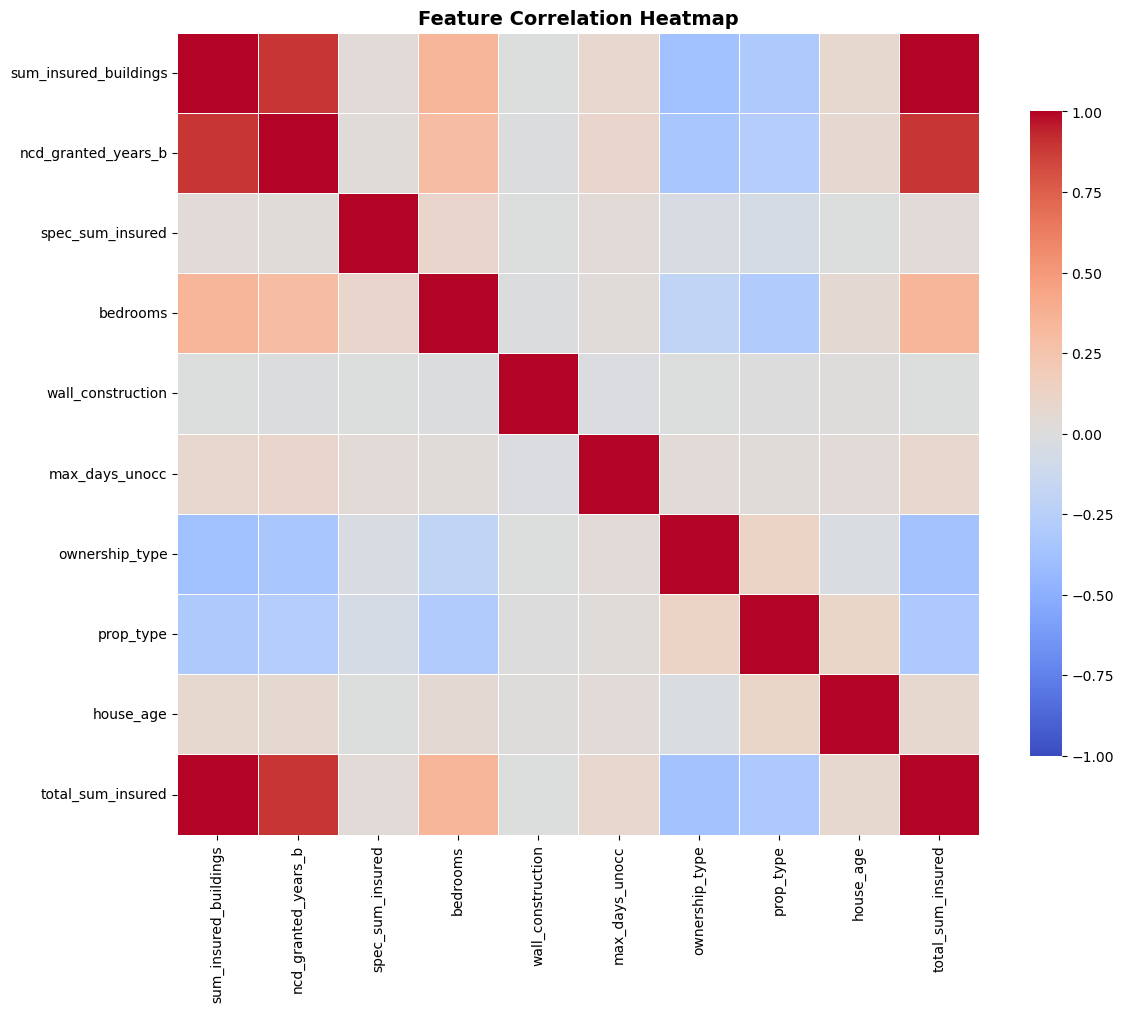

In [29]:
matrix = calculate_correlation_matrix(df=dataset_encoded, numeric_cols=potential_num_vars)
plot_correlation_heatmap(matrix)

This correlation plot shows us that there are a fair few categories that are highly correlated. 

In [30]:
high_corr = find_high_correlations(corr_matrix=matrix, threshold=0.8)
display(high_corr)


Found 3 feature pairs with |correlation| > 0.8


Feature_1,Feature_2,Correlation,Abs_Correlation
str,str,f64,f64
"""sum_insured_buildings""","""total_sum_insured""",0.99967,0.99967
"""sum_insured_buildings""","""ncd_granted_years_b""",0.892838,0.892838
"""ncd_granted_years_b""","""total_sum_insured""",0.892436,0.892436


Looking at these feature pairs. I decided to createa a synthetic varaible that was total sum insured / average ncd years. 

This would then allow me to remove both the ncd granted as wll as total sum insured column from the process.

Correlation matrix calculated using pearson method


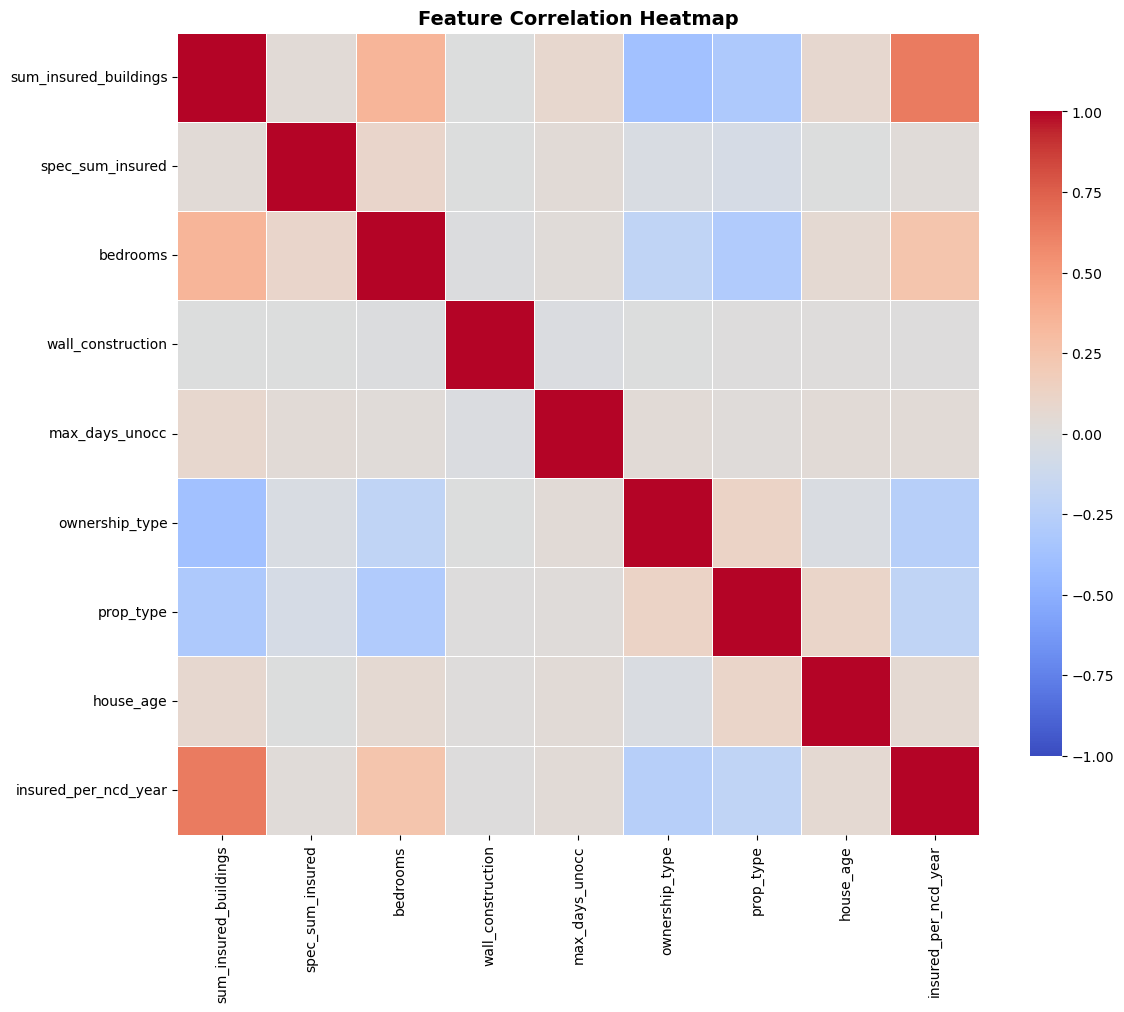


No feature pairs found with |correlation| > 0.8


Feature_1,Feature_2,Correlation,Abs_Correlation
str,str,f64,f64


In [ ]:
dataset_encoded = dataset_encoded.drop(["ncd_granted_years_b", "total_sum_insured"])
potential_num_vars.remove("ncd_granted_years_b")
potential_num_vars.remove("total_sum_insured")
potential_num_vars+= ['insured_per_ncd_year']
matrix = calculate_correlation_matrix(df=dataset_encoded, numeric_cols=potential_num_vars)
plot_correlation_heatmap(matrix)
high_corr = find_high_correlations(corr_matrix=matrix, threshold=0.8)
display(high_corr)


With those removals we have removed any highly correlated variables whilst hopefully maintaining any of the information they had to offer. 

## Further EDA Work

As with lots of EDA there is always more to be done. With more time some of the areas I would have looked into was
- Correlation of the binary / catagorical variables along side the correlations of the numeric variables.
- More multivariate analysis through interaction terms and groupings such as the aggrigations and ratios. 
- Scaling of variables that were going to be used in comparison. The most obvious example being insured price of houses vs contents. The house insurance value will be massive when compared to the value total value of the contents so some form of regularisation would have helped there

# Modeling

For our presentation today I am going to just take us through an XGBoost modeling approach.

The process is broken down into simple steps really. 
- Preprocess
- Train
- Analyse the model

In [54]:
def xgb_pipeline(X_train, y_train, X_test, y_test, scale_pos_weight, feature_cols):
    xgb = modeling.train_xgboost(X_train, y_train, scale_pos_weight=scale_pos_weight, 
                    use_cv=True, random_state=42)
    evaluations = modeling.evaluate_model(xgb, X_test, y_test, model_name="XGB", threshold=0.5)
    importance_df = modeling.analyze_feature_importance(xgb, feature_cols)
    return xgb, evaluations, importance_df

In [55]:
final_var_list = potential_num_vars + potential_cat_vars + ['lapsed_flag']
dataset_encoded = dataset_encoded.select(final_var_list)
model_data = modeling.preprocess_data(df=dataset_encoded, target_col='lapsed_flag')
X_train, X_test, y_train, y_test, feature_cols = modeling.prepare_modeling_data(model_data)
weighting = modeling.calculate_class_weights(y_train)



Encoding categorical columns:
  - p1_emp_status: 11 unique values
  - p1_mar_status: 10 unique values
  - p1_sex: 3 unique values
  - occ_status: 7 unique values
  - payment_method: 3 unique values
Dataset prepared:
  Total samples: 189,005
  Features: 41
  Target distribution:
    Not Lapsed (0): 136,471 (72.2%)
    Lapsed (1): 52,534 (27.8%)
  Imbalance ratio: 2.6:1

Train set: 151,204 samples
  Not Lapsed: 109,177 (72.2%)
  Lapsed: 42,027 (27.8%)

Test set: 37,801 samples
  Not Lapsed: 27,294 (72.2%)
  Lapsed: 10,507 (27.8%)
CLASS WEIGHT CALCULATION
scale_pos_weight: 2.60

This makes the model 2.6x more sensitive to lapse


The training and test data set were build splitting along the target variable so the distribution across both the train and test data sets is maintainted. 

I also created a class weighting to counteract the imbalance we saw between the lapsed and other dataset. This is one of a few possible ways to address the class imbalances


TRAINING XGBOOST
Using scale_pos_weight=2.60

Running 5-fold CV...
CV AUC: 0.7531 (+/- 0.0038)
Training complete

EVALUATING XGB
  AUC-ROC: 0.7557
  Average Precision: 0.5817
  Threshold: 0.50
                Predicted
                No    Yes
Actual No     19419    7875
       Yes     3607    6900
  Precision: 0.467 (of flagged, % actually lapsed)
  Recall: 0.657 (% of lapses caught)
  F1-Score: 0.546
  Specificity: 0.711

  True Positives: 6,900 (caught lapses)
  False Positives: 7,875 (false alarms)
  False Negatives: 3,607 (missed lapses)
  True Negatives: 19,419
  Optimal threshold (f1): 0.50
  Score at optimal: 0.546
  At 0.50: catch 6900/10507 lapses, 7875 false alarms
  At 0.50: catch 6900/10507 lapses, 7875 false alarms

FEATURE IMPORTANCE

Top 20 Features:
shape: (20, 4)
┌───────────────────────┬────────────┬───────────────────────┬────────────────┐
│ feature               ┆ importance ┆ cumulative_importance ┆ cumulative_pct │
│ ---                   ┆ ---        ┆ ---    

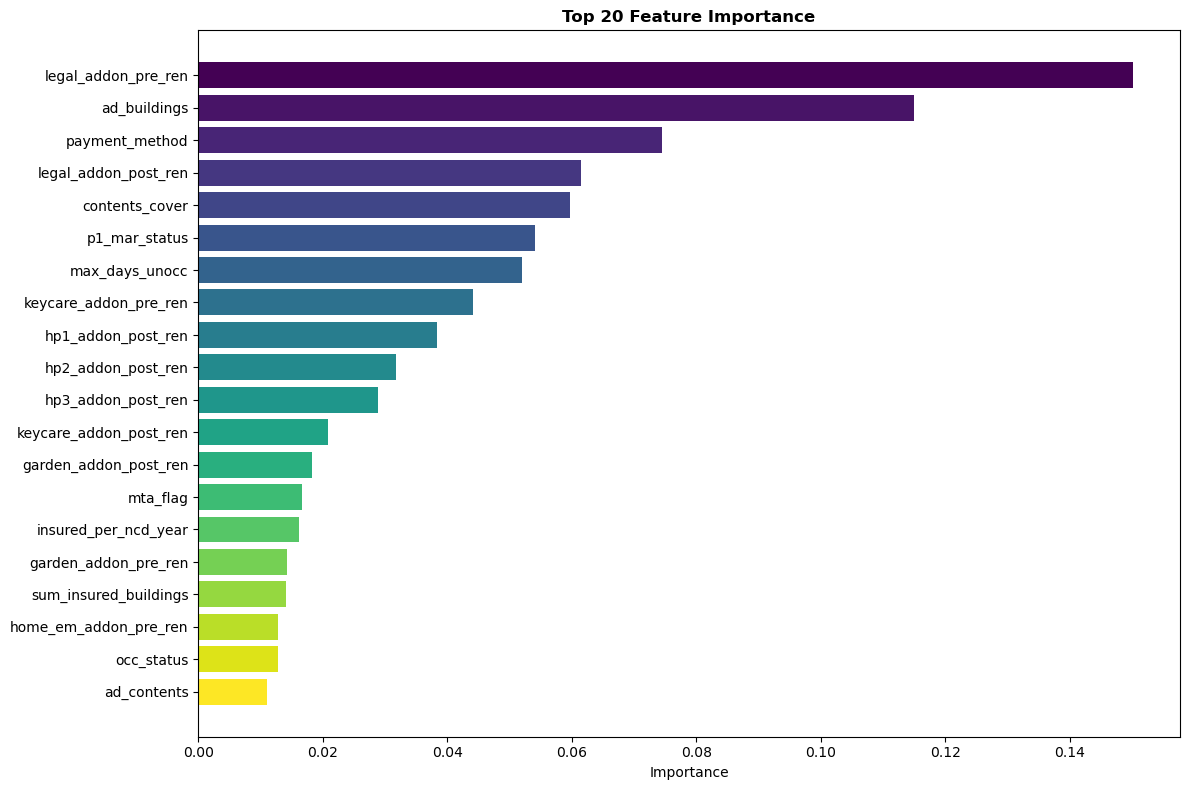

In [57]:
booster, evaluations, importance =  xgb_pipeline(X_train, y_train, X_test, y_test, weighting, feature_cols)

So at first pass this is a perefecly fine model with an AUC of ~.75 which as these models go, not that bad. However when we dig a bit deeper into the analysis we see an F1 score of .55. Whic is not good as it suggests our recall or precision are bad. And wouldn't you know it the preceision (how many false positives) the model has given is below 50%

There are a fair few reasons this could be happening. I have given some below in order of most likely.
- Our features need more work to generate good signals for the model to detect
- The class imbalance weighting is to strong and not fairly setting a penalisation score
- the model itself could do with more hyper parameter tuning  

So in an attempt to improve the model I redid some of my encoding and used WoE and IE scores to create some new varaibles to hopefully improve the model

In [62]:
def calculate_woe(
    df: pl.DataFrame, 
    feature_col: str, 
    target_col: str,
    total_lapses: int,
    total_non_lapses: int,
    epsilon = 0.5
) -> pl.DataFrame:
    """Calculates WoE and IV for a categorical/binned feature in a Polars DataFrame."""
    

    woe_df = df.group_by(feature_col).agg(
        # Lapsed: target=1; Non-Lapsed: target=0
        pl.col(target_col).sum().alias("lapsed_count"),
        (pl.count() - pl.col(target_col).sum()).alias("non_lapsed_count")
    ).with_columns([
        # Add epsilon for smoothing
        (pl.col("lapsed_count") + epsilon).alias("lapsed_smoothed"),
        (pl.col("non_lapsed_count") + epsilon).alias("non_lapsed_smoothed"),
    ])
    
    # Calculate % Distribution and WoE
    woe_df = woe_df.with_columns([
        # % Distribution
        (pl.col("lapsed_smoothed") / total_lapses).alias("lapsed_perc"),
        (pl.col("non_lapsed_smoothed") / total_non_lapses).alias("non_lapsed_perc"),
    ]).with_columns([
        # WoE calculation
        (pl.col("non_lapsed_perc").log() - pl.col("lapsed_perc").log()).alias(f"WoE_{feature_col}")
    ])
    
    # Calculate Information Value (IV)
    woe_df = woe_df.with_columns([
        ((pl.col("non_lapsed_perc") - pl.col("lapsed_perc")) * pl.col(f"WoE_{feature_col}"))
        .alias(f"IV_{feature_col}")
    ])
    
    # The sum of IV is the total feature IV, which you can calculate separately
    return woe_df.select([
        feature_col, 
        f"WoE_{feature_col}",
        f"IV_{feature_col}"
    ])

In [73]:
target_col = 'lapsed_flag'
categorical_cols = [col for col in dataset_encoded.columns 
                       if dataset_encoded[col].dtype == pl.Utf8 and col != target_col]

lapses_flag_count= dataset.group_by(target_col).count()
lapses_count = lapses_flag_count.filter(pl.col(target_col) == 1).select(pl.col('count')).item()
non_lapse_count = lapses_flag_count.filter(pl.col(target_col) == 0).select(pl.col('count')).item()
woe_dataset = dataset_encoded.__copy__()
iv_totals = {}
woe_cols = []
woe_values = pl.DataFrame()
for col in categorical_cols:
    woe_table = calculate_woe(df=woe_dataset,
                              feature_col=col,target_col=target_col,
                               total_lapses=lapses_count, 
                               total_non_lapses=non_lapse_count)
    iv_total =  round(woe_table.select(pl.col(f'IV_{col}').sum()).item(),2)
    iv_totals[col] = iv_total
    if iv_total>=0.02:
        woe_dataset = woe_dataset.join(woe_table.select([col, f"WoE_{col}"]), on=col)
        first_col = woe_table.columns[0]
        woe_table = (woe_table.drop(woe_table.columns[-1]).with_columns(pl.lit(first_col).alias("variable"))
        .rename({first_col: "var", woe_table.columns[1]: "WoE"}).select(["variable", "var", "WoE"]))
        woe_table = woe_table.with_columns(pl.col("var").cast(str))
        woe_values = woe_values.vstack(woe_table)
        woe_cols += [ f"WoE_{col}"]
        
    woe_dataset = woe_dataset.drop(col)

In [80]:
iv_totals

{'p1_emp_status': 0.0,
 'p1_mar_status': 0.2,
 'p1_sex': 0.02,
 'occ_status': 0.0,
 'payment_method': 0.13}

In [79]:
woe_values.filter(pl.col('variable')=='p1_mar_status')

variable,var,WoE
str,str,f64
"""p1_mar_status""","""D""",-0.231951
"""p1_mar_status""","""A""",-0.165379
"""p1_mar_status""","""O""",-0.039959
"""p1_mar_status""","""S""",-0.118226
"""p1_mar_status""","""C""",-0.333595
"""p1_mar_status""","""B""",-0.586927
"""p1_mar_status""","""N""",-0.593638
"""p1_mar_status""","""M""",-0.349269
"""p1_mar_status""","""P""",0.886645


So from encoding the 5 columns selected for WoE calculation ther were 3 that had enough Ifnformation value to be included. These were then saved in a look up table that can be used in inference later to join and provide the WoE score

Dataset prepared:
  Total samples: 189,005
  Features: 39
  Target distribution:
    Not Lapsed (0): 136,471 (72.2%)
    Lapsed (1): 52,534 (27.8%)
  Imbalance ratio: 2.6:1

Train set: 151,204 samples
  Not Lapsed: 109,177 (72.2%)
  Lapsed: 42,027 (27.8%)

Test set: 37,801 samples
  Not Lapsed: 27,294 (72.2%)
  Lapsed: 10,507 (27.8%)

TRAINING XGBOOST
Using scale_pos_weight=2.60

Running 5-fold CV...
CV AUC: 0.7514 (+/- 0.0035)
Training complete

EVALUATING XGB
  AUC-ROC: 0.7542
  Average Precision: 0.5796
  Threshold: 0.50
                Predicted
                No    Yes
Actual No     19415    7879
       Yes     3646    6861
  Precision: 0.465 (of flagged, % actually lapsed)
  Recall: 0.653 (% of lapses caught)
  F1-Score: 0.544
  Specificity: 0.711

  True Positives: 6,861 (caught lapses)
  False Positives: 7,879 (false alarms)
  False Negatives: 3,646 (missed lapses)
  True Negatives: 19,415
  Optimal threshold (f1): 0.50
  Score at optimal: 0.544
  At 0.50: catch 6861/10507 lap

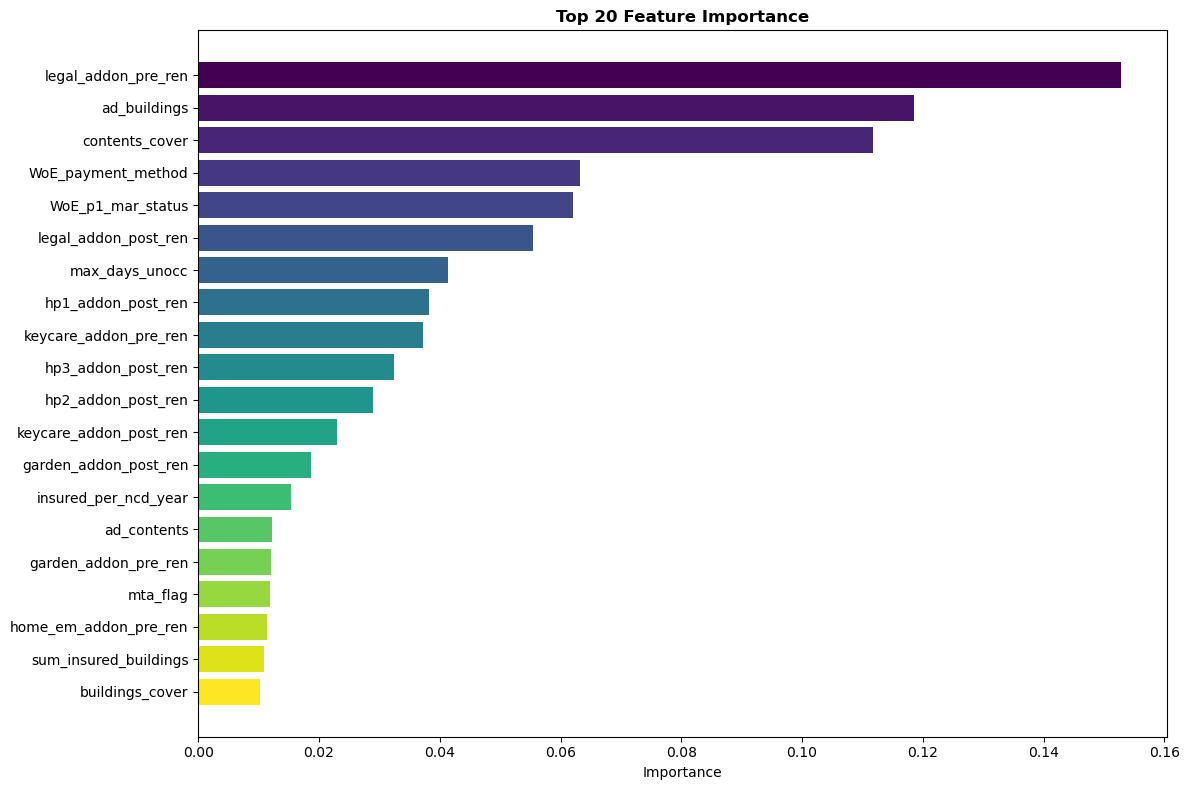

In [81]:
X_train, X_test, y_train, y_test, feature_cols = modeling.prepare_modeling_data(woe_dataset)
xgb_model, evals, features = xgb_pipeline(X_train, y_train, X_test, y_test, weighting, feature_cols)

### Review of WoE
As it Currently stands and only encoding the it Catagorical Variables this has lead to 
- 2 addtional removals from the columns 
- All 3 of these columns are now included in the top 20 variables. 

For full robustness it would be worthwhile encoding the rest of the variables into buckets to allow a full WOE encoding of the dataset. This may lead to improved model performance especialy when combined with Ratio and derived / synthetic feature generation. 

A risk with using this method would be low % chance categories. So going through the variables and grouping up low % encodings to provide an 'other' flag that will prevent the process breaking when there are new / previously unseen catagories, as they can just be assigned to other and as time goes on modeled approapriately with retraining. 

## Model Review

As a first pass this model in my oppinion is fine. It is a useful base line for us to work and improve upon. However as it stands, it is in no way ready for production. 

As already mentioned the models produced have a strong false positive rate that can lead you down the route of missalocated resources, balloning marketing spend and just a lack of trust from internal teams when it comes to your data products. 

So as next steps for this model to improve upon it would be more feature generation and interactions to see if there are any combinations or groupings that have strong predictive power Especially as we see a lot of post and pre renewal flags in the top 20 features. But the low importance across the board suggests that they need work.

Bucketing and encoding can also be used to provide better Encoding options to WoE which should hopefully allow for the model to find different signals. 

Try different modeling techniques as well my help depending on the route to go. More deep learning methods could be used but they would really require a much larger dataset to be performant vs training times. 

Or go simpler with logistic regresions and have something truely explainable with coefficents * value 

# Inference

I have set up a rudimentry process that will create a file with the policies that are a medium risk of churn or higher. 

The intention of this is to allow a file with the policies that are most likely to churn to be created and flagged for the marketing / retention teams to use in targeting their discounts or retention strategies. 

Those that are flagged at high risk probably need some form of immidiate or / high level intervention, those targeted as medium need to be watched and have some level of intervention but not nesscicarily imidiate. 

Anything below that is fine to be targeted by the the usual bau retentions. 

Next steps for that would likely to be spin up a docker image / instance on cloud service to either provide an end point for uploading data as a batch or streamed inferernce process. Or to run as a weekly scheduled process to provide the data unpromped by the other teams.

Using jupyter magic below is the 'logging' output of the proces. If it was to be rolled out to docker or futher refined it would need to have actual logging implimented as well as more robust feature creation so it could handle what could be selected by the model instead of just what is in the one I have currently created.

In [84]:
%%! 
python inference/main.py --input data/home_insurance.parquet --model Models/2025-11-16/xgb_modle.json

["['legal_addon_pre_ren', 'contents_cover', 'ad_buildings', 'legal_addon_post_ren', 'WoE_payment_method', 'WoE_p1_mar_status', 'max_days_unocc', 'keycare_addon_pre_ren', 'hp1_addon_post_ren', 'hp2_addon_post_ren', 'hp3_addon_post_ren', 'keycare_addon_post_ren', 'garden_addon_post_ren', 'sum_insured_buildings', 'garden_addon_pre_ren', 'mta_flag', 'home_em_addon_pre_ren', 'ad_contents', 'house_age', 'bedrooms']",
 'Prediction sample (first 5 rows):',
 'shape: (5, 67)',
 '┌────────────┬─────────────┬────────────┬────────────┬───┬────────────┬─────┬─────────┬────────────┐',
 '│ quote_date ┆ cover_start ┆ claim3year ┆ p1_emp_sta ┆ … ┆ pol_status ┆ i   ┆ police  ┆ predicted_ │',
 '│ ---        ┆ ---         ┆ s          ┆ tus        ┆   ┆ ---        ┆ --- ┆ ---     ┆ risk       │',
 '│ str        ┆ str         ┆ ---        ┆ ---        ┆   ┆ str        ┆ i64 ┆ str     ┆ ---        │',
 '│            ┆             ┆ str        ┆ str        ┆   ┆            ┆     ┆         ┆ f32        │',
 '╞